<a href="https://colab.research.google.com/github/radhikabhakta10/Swire-Cart-Abandonment-/blob/main/Swire_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

In [ ]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define data folder within drive
data_location = "/content/drive/MyDrive/MSBA-CAPSTONE" # change this for your personal data location

In [ ]:
# read in all datasets so our notebook doesn't break
GA = pd.read_csv(f'{data_location}/google_analytics (2).csv')
orders = pd.read_csv(f'{data_location}/orders.csv')
sales = pd.read_csv(f'{data_location}/sales (1).csv')
visit_plan = pd.read_csv(f'{data_location}/visit_plan.csv',
                         dtype={'FREQUENCY':'string'})
customer = pd.read_csv(f'{data_location}/customer.csv')
cutoff_times = pd.read_csv(f'{data_location}/cutoff_times.csv')
operating_hours = pd.read_csv(f'{data_location}/operating_hours.csv')
material = pd.read_csv(f'{data_location}/material.csv')

# Preprocessing

Main goal: Calculate abandoned carts


### Mapping Tables



In [ ]:
frequency_map = {
     '02':2, '01':1, '04':4, 'Every Second Week On':2,
     'Every Week On':1, 'Every Fourth Week On':4,
     'Every Third Week On':3, 'Every Tenth Week On':10, '03':3,
     'Every Fifth Week On':5, 'Every Eighth Week On':8,
     'Every 4 Weeks':4, 'Every Sixth Week On':6, 'Every 2 Weeks':2,
     'Every Week':1, '1 ':1, '2 ':2, '4 ':4, '3 ':3, '10':10, '05':5,
     '5 ':5, '8 ':8, '08':8, '06':6
}

sales_office_timezone_map = {
    'Glenwood Springs, CO': 'America/Denver',
    'Denver, CO': 'America/Denver',
    'Draper, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Pocatello, ID': 'America/Boise', # Southern Idaho is Mountain Time
    'Tempe, AZ': 'America/Phoenix', # Arizona does not observe Daylight Saving Time
    'Scottsbluff, NE': 'America/Denver', # Western Nebraska is Mountain Time
    'Albuquerque, NM': 'America/Denver',
    'Twin Falls, ID': 'America/Boise', # Southern Idaho is Mountain Time
    'Bellevue, WA': 'America/Los_Angeles', # Pacific Time
    'Glendale, AZ': 'America/Phoenix',
    'Kingman, AZ': 'America/Phoenix',
    'Johnstown, CO': 'America/Denver',
    'Tucson, AZ': 'America/Phoenix',
    'Arlington, WA': 'America/Los_Angeles',
    'Eugene, OR': 'America/Los_Angeles', # Pacific Time
    'Ogden, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Bremerton, WA': 'America/Los_Angeles',
    'Boise, ID': 'America/Boise', # Mountain Time
    'Price, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Cheyenne, WY': 'America/Denver',
    'Elko, NV': 'America/Los_Angeles', # Most of Nevada is Pacific Time
    'Tacoma, WA': 'America/Los_Angeles',
    'Huachuca City, AZ': 'America/Phoenix',
    'Reno, NV': 'America/Los_Angeles', # Most of Nevada is Pacific Time
    'Wilsonville, OR': 'America/Los_Angeles',
    'Colorado Springs, CO': 'America/Denver',
    'Idaho Falls, ID': 'America/Boise', # Southern Idaho is Mountain Time
    'Spokane, WA': 'America/Los_Angeles', # Pacific Time
    'Wenatchee, WA': 'America/Los_Angeles',
    'Pendleton, OR': 'America/Los_Angeles', # Most of Oregon is Pacific Time
    'Pueblo, CO': 'America/Denver',
    'Alamosa, CO': 'America/Denver',
    'Flagstaff, AZ': 'America/Phoenix',
    'Walla Walla, WA': 'America/Los_Angeles',
    'Bend, OR': 'America/Los_Angeles', # Most of Oregon is Pacific Time
    'LaGrande, OR': 'America/Boise', # Part of Oregon is Mountain Time
    'Logan, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Grand Junction, CO': 'America/Denver',
    'Richfield, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Lewiston, ID': 'America/Los_Angeles', # Northern Idaho is Pacific Time
    'Prescott, AZ': 'America/Phoenix',
    'Yuma, AZ': 'America/Phoenix',
    'Show Low, AZ': 'America/Phoenix',
    'Chinle, AZ': 'America/Denver', # Navajo Nation observes Daylight Saving Time and uses Mountain Time
    np.nan: None # Handle NaN values
}

distribution_mode_map = {
    'SL': 'Sideload',
    'OF': 'OFS',
    'EZ': 'E Pallet',
    'RD': 'Rapid Delivery',
    'NR': 'Night Rapid Delivery',
    'FS': 'Full Service',
    'BK': 'Bulk Distribution',
    'SE': 'Special Events',
    'NS': 'Night Sideload',
    'NO': 'Night OFS',
    'DD': 'Direct Store Delivery',
    np.nan: None
}

shipping_conditions_map = {
    '48 Hours': '48hrs',
    '24 Hours': '24hrs',
    '72 Hours': '72hrs',
    'Dropsite 48 Hours': '48hrs',
    np.nan: None,
    'Dropsite 72 Hours': '72hrs',
    'Dropsite 24 Hours': '24hrs'
}

## Calculating Order Windows

To Calculate Order Windows, We'll first need to clean the visit plan table and calculate the exact anchor datetimes/frequencies.

Then, with this information, we'll calculate order windows

### Cleaning Visit Plan

In [ ]:
# Function to combine date and time
def combine_date_time(row):
    # Check if ANCHOR_DATE is NaT
    if pd.isna(row['ANCHOR_DATE']):
        return pd.NaT # Return NaT if ANCHOR_DATE is NaT

    date = row['ANCHOR_DATE'].date()
    if pd.isnull(row['CUTOFFTIME__C']):
        time_str = '17:00:00' # 5:00 PM
    else:
        try:
            time_obj = pd.to_datetime(row['CUTOFFTIME__C']).time()
            time_str = time_obj.strftime('%H:%M:%S')
        except:
            time_str = '17:00:00' # Default to 5:00 PM

    datetime_str = f'{date} {time_str}'
    return pd.to_datetime(datetime_str)


def clean_visit_plan(visit_plan):

    # remove customers with missing important info
    # define list of customer id's to exclude
    cust_exclude = [
        600565083, 500714888, 501652104, 501653011, 500312987, 501226870, 500995978, 501654391, 501585173, 501297027, 501364983, 600581129, 501202498
    ]

    # drop these customers from the visit plan table
    visit_plan = visit_plan[~visit_plan['CUSTOMER_ID'].isin(cust_exclude)]



    # fill in missing frequency data
    # join the visit plan with the operating hours table to get our best estimate of FREQUENCY and ANCHOR_DATE
    visit_plan = visit_plan.merge(
        operating_hours,
        left_on='CUSTOMER_ID',
        right_on='CUSTOMER_NUMBER',
        how='left'
    )

    # fill the null values in FREQUENCY_x and ANCHOR_DATE with the values in FREQUENCY_y and CALLING_ANCHOR_DATE
    visit_plan['FREQUENCY_x'] = visit_plan['FREQUENCY_x'].fillna(visit_plan['FREQUENCY_y'])
    visit_plan['ANCHOR_DATE'] = visit_plan['ANCHOR_DATE'].fillna(visit_plan['CALLING_ANCHOR_DATE'])

    # rename the FREQUENCY_x column to FREQUENCY
    visit_plan = visit_plan.rename(columns={'FREQUENCY_x': 'FREQUENCY'})

    # drop the remaining columns that weren't originally in the visit plan table
    visit_plan = visit_plan.drop(columns=['CUSTOMER_NUMBER', 'FREQUENCY_y', 'DELIVERY_ANCHOR_DAY', 'CALLING_ANCHOR_DATE'])



    # map values in the frequency column to integers for calculating whether carts are abandoned.
    visit_plan['FREQUENCY'] = visit_plan['FREQUENCY'].map(frequency_map)


    # calculate Anchor datetimes in UTC

    # map the distribution mode and shipping conditions so we can join to cutoff_times
    visit_plan['DISTRIBUTION_MODE'] = visit_plan['DISTRIBUTION_MODE'].map(distribution_mode_map)
    visit_plan['SHIPPING_CONDITIONS_DESC'] = visit_plan['SHIPPING_CONDITIONS_DESC'].map(shipping_conditions_map)

    # Convert date columns to datetime, coercing errors
    visit_plan['ANCHOR_DATE'] = pd.to_datetime(visit_plan['ANCHOR_DATE'], errors='coerce')
    visit_plan['ELT_TS'] = pd.to_datetime(visit_plan['ELT_TS'], errors='coerce', utc=True) # assuming ELT_TS is in UTC
    visit_plan['SNAPSHOT_DATE'] = pd.to_datetime(visit_plan['SNAPSHOT_DATE'], errors='coerce')

    # remove snapshots that are outside of the GA time period.
    visit_plan = visit_plan[
        (visit_plan['SNAPSHOT_DATE'] >= '2024-05-31') &
        (visit_plan['SNAPSHOT_DATE'] <= '2025-05-26')]

    # Sort the visit_plan DataFrame by CUSTOMER_ID and ELT_TS and remove duplicates based on the specified columns, keeping the first occurrence
    visit_plan = visit_plan.sort_values(by=['CUSTOMER_ID', 'ELT_TS'])
    visit_plan = visit_plan.drop_duplicates(subset=['CUSTOMER_ID', 'FREQUENCY', 'ANCHOR_DATE', 'SALES_OFFICE', 'SALES_OFFICE_DESC', 'DISTRIBUTION_MODE', 'SHIPPING_CONDITIONS_DESC'], keep='first')

    # get anchor datetimes and convert to UTC

    # Perform a left join between visit_plan and cutoff_times
    visit_plan = visit_plan.merge(
        cutoff_times,
        left_on=['SALES_OFFICE_DESC', 'SHIPPING_CONDITIONS_DESC', 'DISTRIBUTION_MODE'],
        right_on=['SALES_OFFICE', 'SHIPPING_CONDITION_TIME', 'DISTRIBUTION_MODE'],
        how='left'
    )

    # Apply the function to create the new datetime column
    visit_plan['ANCHOR_DATETIME'] = visit_plan.apply(combine_date_time, axis=1)

    # Remove extra columns from cutoff_times
    visit_plan = visit_plan.drop(columns=['SALES_OFFICE_y', 'PLANT_ID', 'CUTOFFTIME__C', 'SHIPPING_CONDITION_TIME'])

    # Rename SALES_OFFICE_x to SALES OFFICE
    visit_plan = visit_plan.rename(columns={'SALES_OFFICE_x': 'SALES_OFFICE'})

    # Create TIMEZONE column by mapping SALES_OFFICE_DESC
    visit_plan['TIMEZONE'] = visit_plan['SALES_OFFICE_DESC'].map(sales_office_timezone_map)

    # Convert ANCHOR_DATETIME to UTC
    # First, localize the datetime to the respective timezone, then convert to UTC
    # Handle NaT values before timezone conversion
    visit_plan['ANCHOR_DATETIME_UTC'] = pd.NaT
    for index, row in visit_plan.iterrows():
        if pd.notna(row['ANCHOR_DATETIME']) and row['TIMEZONE']:
            try:
                local_dt = row['ANCHOR_DATETIME'].tz_localize(row['TIMEZONE'])
                visit_plan.loc[index, 'ANCHOR_DATETIME_UTC'] = local_dt.tz_convert('UTC')
            except pytz.UnknownTimeZoneError:
                # Handle cases where timezone is not recognized
                visit_plan.loc[index, 'ANCHOR_DATETIME_UTC'] = pd.NaT

    # Remove rows where ANCHOR_DATETIME_UTC is NaT
    visit_plan = visit_plan.dropna(subset=['ANCHOR_DATETIME_UTC'])

    return visit_plan

In [ ]:
# test the function
visit_plan = pd.read_csv(f'{data_location}/visit_plan.csv',
                         dtype={'FREQUENCY':'string'})
visit_plan = clean_visit_plan(visit_plan)
display(visit_plan)

/tmp/ipython-input-3555368472.py:109: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2020-04-08 23:00:00+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  visit_plan.loc[index, 'ANCHOR_DATETIME_UTC'] = local_dt.tz_convert('UTC')


,CUSTOMER_ID,FREQUENCY,ELT_TS,SNAPSHOT_DATE,ANCHOR_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,ANCHOR_DATETIME,TIMEZONE,ANCHOR_DATETIME_UTC
0,500245685,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2020-04-08,G111,"Draper, UT",OFS,48hrs,2020-04-08 17:00:00,America/Denver,2020-04-08 23:00:00+00:00
1,500245685,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2023-04-24,G111,"Draper, UT",OFS,48hrs,2023-04-24 17:00:00,America/Denver,2023-04-24 23:00:00+00:00
2,500245685,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2020-04-06,G111,"Draper, UT",OFS,48hrs,2020-04-06 17:00:00,America/Denver,2020-04-06 23:00:00+00:00
3,500245685,1,2024-12-16 02:40:41.679000+00:00,2024-12-15,2024-11-18,G111,"Draper, UT",OFS,48hrs,2024-11-18 17:00:00,America/Denver,2024-11-19 00:00:00+00:00
4,500245689,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2099-12-31,G111,"Draper, UT",OFS,48hrs,2099-12-31 17:00:00,America/Denver,2100-01-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
22527,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-03,G282,"Wenatchee, WA",OFS,48hrs,2024-07-03 15:30:00,America/Los_Angeles,2024-07-03 22:30:00+00:00
22528,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-01,G282,"Wenatchee, WA",OFS,48hrs,2024-07-01 15:30:00,America/Los_Angeles,2024-07-01 22:30:00+00:00
22529,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2020-10-01,G282,"Wenatchee, WA",OFS,48hrs,2020-10-01 15:30:00,America/Los_Angeles,2020-10-01 22:30:00+00:00
22530,600975318,2,2025-05-12 01:38:03.863000+00:00,2025-05-11,2025-04-14,G282,"Wenatchee, WA",OFS,48hrs,2025-04-14 15:30:00,America/Los_Angeles,2025-04-14 22:30:00+00:00


In [ ]:
import pandas as pd

def filter_anchor_dates(visit_plan: pd.DataFrame) -> pd.DataFrame:
    """
    Filters `visit_plan` so that:
      1. Rows with ANCHOR_DATE between May 2024 and May 2025 (inclusive of May 1, 2024,
         exclusive of June 1, 2025) are kept.
      2. If a customer has no anchor dates in that range, keep only rows
         where that customer has their maximum ANCHOR_DATE.
    All other columns are retained.
    """

    df = visit_plan.copy()
    df["ANCHOR_DATE"] = pd.to_datetime(df["ANCHOR_DATE"], errors="coerce")

    # Define the date window
    start = pd.Timestamp("2024-05-01")
    end = pd.Timestamp("2025-06-01")

    # Step 1: mark rows in date window
    in_window = (df["ANCHOR_DATE"] >= start) & (df["ANCHOR_DATE"] < end)

    # Step 2: detect which customers have any row in that window
    # Corrected logic to use transform on the boolean Series
    has_window = df.groupby("CUSTOMER_ID")['ANCHOR_DATE'].transform(lambda x: in_window[x.index].any())


    # Step 3: keep window rows if they exist for that customer
    df_in_window = df[in_window & has_window].copy()

    # Step 4: for customers without window rows, keep only max anchor date rows
    df_no_window = df[~has_window].copy()
    max_anchor = (
        df_no_window.groupby("CUSTOMER_ID", as_index=False)["ANCHOR_DATE"].max()
        .rename(columns={"ANCHOR_DATE": "_max_anchor"})
    )

    df_no_window = df_no_window.merge(max_anchor, on="CUSTOMER_ID", how="left")
    df_no_window = df_no_window[df_no_window["ANCHOR_DATE"] == df_no_window["_max_anchor"]].copy()
    df_no_window = df_no_window.drop(columns="_max_anchor")

    # Step 5: combine results and return all original columns
    filtered = pd.concat([df_in_window, df_no_window], ignore_index=True)
    filtered = filtered.sort_values(["CUSTOMER_ID", "ANCHOR_DATE"]).reset_index(drop=True)

    return filtered

# Example usage:
visit_plan = filter_anchor_dates(visit_plan.copy())
display(visit_plan)

,CUSTOMER_ID,FREQUENCY,ELT_TS,SNAPSHOT_DATE,ANCHOR_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,ANCHOR_DATETIME,TIMEZONE,ANCHOR_DATETIME_UTC
0,500245685,1,2024-12-16 02:40:41.679000+00:00,2024-12-15,2024-11-18,G111,"Draper, UT",OFS,48hrs,2024-11-18 17:00:00,America/Denver,2024-11-19 00:00:00+00:00
1,500245689,1,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-20,G111,"Draper, UT",OFS,48hrs,2024-11-20 17:00:00,America/Denver,2024-11-21 00:00:00+00:00
2,500245690,2,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-25,G111,"Draper, UT",OFS,48hrs,2024-11-25 17:00:00,America/Denver,2024-11-26 00:00:00+00:00
3,500245724,4,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-18,G111,"Draper, UT",OFS,48hrs,2024-11-18 17:00:00,America/Denver,2024-11-19 00:00:00+00:00
4,500245736,1,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-21,G111,"Draper, UT",OFS,48hrs,2024-11-21 17:00:00,America/Denver,2024-11-22 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
13049,600975280,4,2025-05-12 01:38:03.863000+00:00,2025-05-11,2025-04-18,G282,"Wenatchee, WA",OFS,48hrs,2025-04-18 15:30:00,America/Los_Angeles,2025-04-18 22:30:00+00:00
13050,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-01,G282,"Wenatchee, WA",OFS,48hrs,2024-07-01 15:30:00,America/Los_Angeles,2024-07-01 22:30:00+00:00
13051,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-03,G282,"Wenatchee, WA",OFS,48hrs,2024-07-03 15:30:00,America/Los_Angeles,2024-07-03 22:30:00+00:00
13052,600975318,2,2025-05-12 01:38:03.863000+00:00,2025-05-11,2025-04-14,G282,"Wenatchee, WA",OFS,48hrs,2025-04-14 15:30:00,America/Los_Angeles,2025-04-14 22:30:00+00:00


# Calculating Order Windows

In [ ]:
from datetime import timedelta

visit_plan["cycle_days"] = visit_plan["FREQUENCY"] * 7

# define function to find the possible order windows for each customer (data only goes from 05-2024 to 05-2025 but I left a buffer on either side)
def build_order_windows(row, start="2024-01-01", end="2025-12-31"):
    # make start and end timestamps timezone-aware (UTC)
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    t = pd.Timestamp(row["ANCHOR_DATETIME_UTC"])
    cycle = pd.Timedelta(days=row["cycle_days"])

    # move forward if anchor is before the global start
    while t + cycle < start:
        t += cycle

    windows = []
    while t < end:
        windows.append({
            "CUSTOMER_ID": row["CUSTOMER_ID"],
            "window_start": t,
            "window_end": t + cycle,
            "FREQUENCY": row["FREQUENCY"],
            "ANCHOR_DATE": row["ANCHOR_DATETIME_UTC"],
            "SALES_OFFICE": row["SALES_OFFICE"],
        })
        t += cycle
    return pd.DataFrame(windows)

# this function will build every possible order window within the date range above for each visit plan
windows = pd.concat([build_order_windows(r) for _, r in visit_plan.iterrows()])
display(windows)

,CUSTOMER_ID,window_start,window_end,FREQUENCY,ANCHOR_DATE,SALES_OFFICE
0,500245685,2024-11-19 00:00:00+00:00,2024-11-26 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
1,500245685,2024-11-26 00:00:00+00:00,2024-12-03 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
2,500245685,2024-12-03 00:00:00+00:00,2024-12-10 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
3,500245685,2024-12-10 00:00:00+00:00,2024-12-17 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
4,500245685,2024-12-17 00:00:00+00:00,2024-12-24 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
...,...,...,...,...,...,...
14,600975318,2025-11-03 22:30:00+00:00,2025-11-17 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282
15,600975318,2025-11-17 22:30:00+00:00,2025-12-01 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282
16,600975318,2025-12-01 22:30:00+00:00,2025-12-15 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282
17,600975318,2025-12-15 22:30:00+00:00,2025-12-29 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282


In [ ]:
GA_filtered = GA[GA['EVENT_NAME'].isin(['add_to_cart', 'purchase'])].copy()

GA_filtered['EVENT_TIMESTAMP'] = pd.to_datetime(GA_filtered['EVENT_TIMESTAMP'], utc=True)

# Perform a simple left join on CUSTOMER_ID
events_with_windows = pd.merge(
    GA_filtered,
    windows[["CUSTOMER_ID", "window_start", "window_end"]],
    on="CUSTOMER_ID",
    how="left"
)

# keep only events that are in the order window (this filter is still necessary even with a simple join)
in_window_mask = (
    events_with_windows["window_start"].notna()
    & (events_with_windows["EVENT_TIMESTAMP"] >= events_with_windows["window_start"])
    & (events_with_windows["EVENT_TIMESTAMP"] <  events_with_windows["window_end"])
)
events_in_windows = events_with_windows.loc[in_window_mask].copy()


# add flags for purchase events and add events
events_in_windows["is_purchase"] = (events_in_windows["EVENT_NAME"] == "purchase").astype(int)
events_in_windows["is_add"]      = (events_in_windows["EVENT_NAME"] == "add_to_cart").astype(int)

win_summary = (
    events_in_windows
      .groupby(["CUSTOMER_ID", "window_start", "window_end"], as_index=False)
      .agg(had_add=("is_add","max"),
           had_purchase=("is_purchase","max"),
           n_events=("EVENT_NAME","size"))
)

# define abandoned as a customer with an add within the window but no purchase
win_summary["Abandoned"] = ((win_summary["had_add"]==1) & (win_summary["had_purchase"]==0)).astype(int)

display(win_summary)

# add list of event types and items

,CUSTOMER_ID,window_start,window_end,had_add,had_purchase,n_events,Abandoned
0,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00,1,1,2,0
1,500245685,2025-03-18 00:00:00+00:00,2025-03-25 00:00:00+00:00,1,1,2,0
2,500245685,2025-04-15 00:00:00+00:00,2025-04-22 00:00:00+00:00,1,1,2,0
3,500245685,2025-04-29 00:00:00+00:00,2025-05-06 00:00:00+00:00,1,1,2,0
4,500245738,2024-07-19 21:30:00+00:00,2024-07-26 21:30:00+00:00,1,1,2,0
...,...,...,...,...,...,...,...
33572,600975276,2025-04-29 22:30:00+00:00,2025-05-13 22:30:00+00:00,1,1,12,0
33573,600975276,2025-05-02 22:30:00+00:00,2025-05-09 22:30:00+00:00,1,1,12,0
33574,600975280,2025-04-18 22:30:00+00:00,2025-05-16 22:30:00+00:00,1,1,17,0
33575,600975280,2025-04-24 22:30:00+00:00,2025-05-01 22:30:00+00:00,1,0,1,1


In [ ]:
# calculate the number of abandoned carts per customer
abandoned_carts_per_customer = win_summary.groupby(['CUSTOMER_ID', 'window_start'])['Abandoned'].sum().reset_index()
abandoned_carts_per_customer = abandoned_carts_per_customer.rename(columns={'Abandoned': 'abandoned_cart_count'})

abandoned_carts_per_customer

abandoned_carts_per_customer.sort_values(["abandoned_cart_count"], ascending = False).reset_index(drop=True)

,CUSTOMER_ID,window_start,abandoned_cart_count
0,501645690,2025-05-02 21:00:00+00:00,2
1,501676877,2025-02-11 00:00:00+00:00,2
2,501543383,2024-10-01 00:00:00+00:00,2
3,501293875,2025-05-17 01:00:00+00:00,2
4,500567350,2025-04-30 01:00:00+00:00,2
...,...,...,...
33016,600975210,2025-04-14 22:30:00+00:00,0
33017,600975210,2025-04-16 22:30:00+00:00,0
33018,600975210,2025-04-23 22:30:00+00:00,0
33019,500245738,2024-08-16 23:00:00+00:00,0


In [ ]:
# generating simple table to flag customers with abandoned carts
customer_abandonment_summary = win_summary.groupby(['CUSTOMER_ID', 'window_start'])['Abandoned'].max().reset_index()
customer_abandonment_summary = customer_abandonment_summary.rename(columns={'Abandoned': 'had_abandoned_cart'})

In [ ]:
# some summary stats (this is on a subset so counts arent accurate for entire dataset)
total_customers = len(customer_abandonment_summary)
customers_with_abandoned_carts = customer_abandonment_summary['had_abandoned_cart'].sum()
percentage_with_abandoned_carts = (customers_with_abandoned_carts / total_customers) * 100

print(f"Total order windows: {total_customers}")
print(f"Windows with abandoned carts: {customers_with_abandoned_carts}")
print(f"Percentage of windows with abandoned carts: {percentage_with_abandoned_carts:.2f}%")

Total order windows: 33021
Windows with abandoned carts: 4850
Percentage of windows with abandoned carts: 14.69%


In [ ]:
import pandas as pd
import numpy as np

# this code attempts to identify recovered carts

win = win_summary.copy()
orders2 = orders.copy()

# same datetime functions applied, can change if needed
win["window_start"] = pd.to_datetime(win["window_start"]).dt.tz_localize(None)
win["window_end"]   = pd.to_datetime(win["window_end"]).dt.tz_localize(None)
orders2["order_ts"] = pd.to_datetime(orders2["CREATED_DATE_UTC"]).dt.tz_localize(None)

# keep only abandoned windows
abandoned = win.loc[win["Abandoned"] == 1].copy()

# for each abandoned window, attach the *next* order AFTER window_end (per customer)
abandoned = abandoned.sort_values(["window_end"]).reset_index(drop=True)
orders2   = orders2.sort_values(["order_ts"]).reset_index(drop=True)


# use forward asof to get the first order at/after window_end
next_order = pd.merge_asof(
    abandoned,
    orders2,
    left_on="window_end",
    right_on="order_ts",
    by="CUSTOMER_ID",
    direction="forward",
    allow_exact_matches=False,  # use True if you consider an order exactly at window_end as "after"
)

# looking to see if there was a purchase in the next window
win_sorted = win.sort_values(["CUSTOMER_ID","window_end"], kind="mergesort")
win_sorted["next_window_end"] = (
    win_sorted.groupby("CUSTOMER_ID")["window_end"].shift(-1)
)

# merge in the next_window_end for the same abandoned row
next_order = next_order.merge(
    win_sorted[["CUSTOMER_ID","window_end","next_window_end"]],
    on=["CUSTOMER_ID","window_end"],
    how="left"
)

next_order["Recovered_before_next_window_end"] = (
    next_order["order_ts"].notna()
    & next_order["next_window_end"].notna()
    & (next_order["order_ts"] < next_order["next_window_end"])
).astype(int)

next_order["time_to_recovery_days"] = np.where(
    next_order["order_ts"].notna(),
    (next_order["order_ts"] - next_order["window_end"]) / np.timedelta64(1, "D"),
    np.nan
)

# label columns
recovery_cols = [
    "CUSTOMER_ID","window_start","window_end","order_ts", "Recovered_before_next_window_end",
    "time_to_recovery_days"
]
recovered_flags = next_order[recovery_cols]

win_with_recovery = win.merge(
    recovered_flags,
    on=["CUSTOMER_ID","window_start","window_end"],
    how="left"
)

for col in ["Recovered_before_next_window_end"]:
    win_with_recovery[col] = win_with_recovery[col].fillna(0).astype(int)

display(win_with_recovery)


,CUSTOMER_ID,window_start,window_end,had_add,had_purchase,n_events,Abandoned,order_ts,Recovered_before_next_window_end,time_to_recovery_days
0,500245685,2025-02-18 00:00:00,2025-02-25 00:00:00,1,1,2,0,NaT,0,NaN
1,500245685,2025-03-18 00:00:00,2025-03-25 00:00:00,1,1,2,0,NaT,0,NaN
2,500245685,2025-04-15 00:00:00,2025-04-22 00:00:00,1,1,2,0,NaT,0,NaN
3,500245685,2025-04-29 00:00:00,2025-05-06 00:00:00,1,1,2,0,NaT,0,NaN
4,500245738,2024-07-19 21:30:00,2024-07-26 21:30:00,1,1,2,0,NaT,0,NaN
...,...,...,...,...,...,...,...,...,...,...
33714,600975276,2025-04-29 22:30:00,2025-05-13 22:30:00,1,1,12,0,NaT,0,NaN
33715,600975276,2025-05-02 22:30:00,2025-05-09 22:30:00,1,1,12,0,NaT,0,NaN
33716,600975280,2025-04-18 22:30:00,2025-05-16 22:30:00,1,1,17,0,NaT,0,NaN
33717,600975280,2025-04-24 22:30:00,2025-05-01 22:30:00,1,0,1,1,2025-05-06 22:50:17,1,5.014086


===== Summary Counts =====
Total Windows                       33719
Recovered before next window        2362

Recovery Rate (among Abandoned): 46.82%


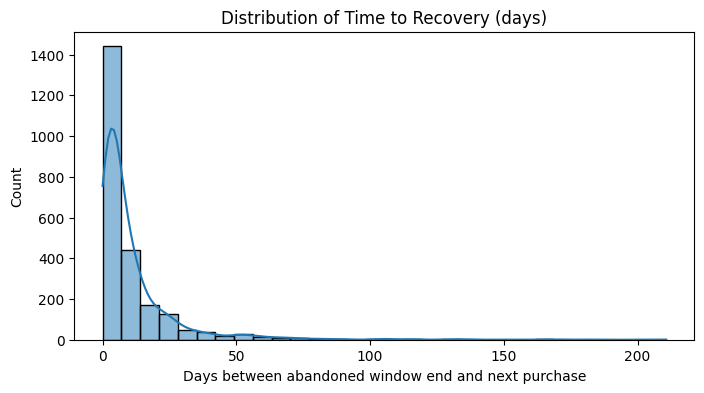

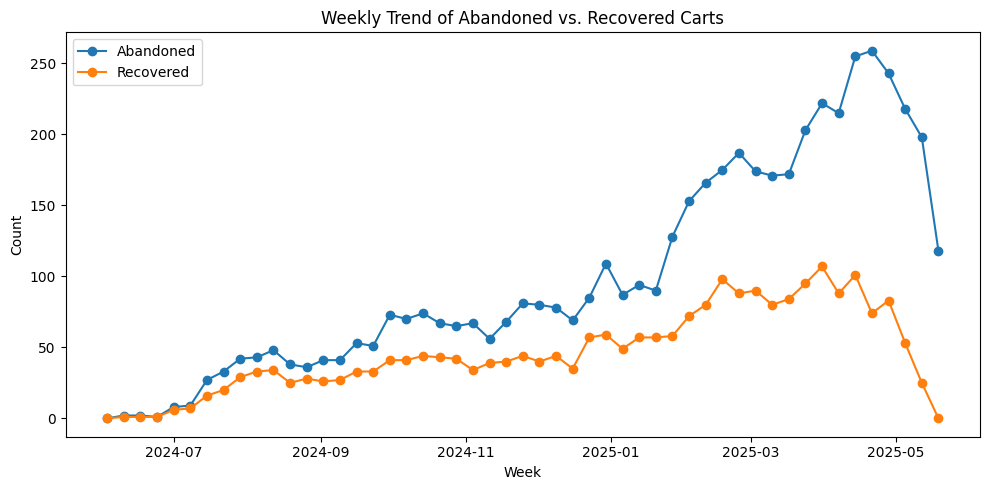

In [ ]:
# now i had ai generate a bunch of summary stats, but the numbers dont 100% tie out so i need to check this one

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume your final dataframe is called:
df = win_with_recovery.copy()

# --- 1️⃣ High-level counts ---
summary_counts = {
    "Total Windows": len(df),
    "Recovered before next window": df["Recovered_before_next_window_end"].sum(),
}

print("===== Summary Counts =====")
for k, v in summary_counts.items():
    print(f"{k:35s} {v}")

# --- 2️⃣ Conversion rates ---
df["Recovered_before_next_window_end"] = df["Recovered_before_next_window_end"].astype(int)
recovery_rate = (
    df.loc[df["Abandoned"] == 1, "Recovered_before_next_window_end"].mean() * 100
)
print(f"\nRecovery Rate (among Abandoned): {recovery_rate:.2f}%")

# --- 3️⃣ Summary by frequency (policy-level view) ---
if "FREQUENCY" in df.columns:
    policy_summary = (
        df.groupby("FREQUENCY")
        .agg(
            windows=("window_start", "size"),
            abandoned=("Abandoned", "sum"),
            recovered=("Recovered_before_next_window_end", "sum"),
        )
        .assign(
            abandoned_rate=lambda x: 100 * x["abandoned"] / x["windows"],
            recovery_rate=lambda x: 100 * x["recovered"] / x["abandoned"].clip(lower=1),
        )
    )
    print("\n===== Summary by Frequency (weeks between orders) =====")
    display(policy_summary)

# --- 4️⃣ Time-to-recovery distribution ---
plt.figure(figsize=(8, 4))
sns.histplot(
    df.loc[df["Recovered_before_next_window_end"] == 1, "time_to_recovery_days"],
    bins=30,
    kde=True
)
plt.title("Distribution of Time to Recovery (days)")
plt.xlabel("Days between abandoned window end and next purchase")
plt.ylabel("Count")
plt.show()

# --- 6️⃣ Optional: weekly trend of abandon/recovery over time ---
df["window_start_week"] = df["window_start"].dt.to_period("W").dt.start_time
weekly = (
    df.groupby("window_start_week")
    .agg(abandoned=("Abandoned", "sum"), recovered=("Recovered_before_next_window_end", "sum"))
    .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(weekly["window_start_week"], weekly["abandoned"], label="Abandoned", marker="o")
plt.plot(weekly["window_start_week"], weekly["recovered"], label="Recovered", marker="o")
plt.title("Weekly Trend of Abandoned vs. Recovered Carts")
plt.xlabel("Week")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


# Answering Q1,2 - Radhika

### Ensuring Recovered and Abandondoned Carts are Flagged

In [ ]:
# Read in full_events_in_windows.csv
import pandas as pd

full_events_in_windows = pd.read_csv("full_events_in_windows.csv")

In [ ]:
full_events_in_windows.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00+00:00,2025-04-09 22:00:00+00:00
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00


In [ ]:
# Inspect
win_with_recovery.head()

,CUSTOMER_ID,window_start,window_end,had_add,had_purchase,n_events,Abandoned,order_ts,Recovered_before_next_window_end,time_to_recovery_days
0,500245685,2025-02-18 00:00:00,2025-02-25 00:00:00,1,1,2,0,NaT,0,NaN
1,500245685,2025-03-18 00:00:00,2025-03-25 00:00:00,1,1,2,0,NaT,0,NaN
2,500245685,2025-04-15 00:00:00,2025-04-22 00:00:00,1,1,2,0,NaT,0,NaN
3,500245685,2025-04-29 00:00:00,2025-05-06 00:00:00,1,1,2,0,NaT,0,NaN
4,500245738,2024-07-19 21:30:00,2024-07-26 21:30:00,1,1,2,0,NaT,0,NaN


In [ ]:
# How far from the window did people purchase
df['purchase_gap_from_window_end'] = (df['order_ts'] - df['window_end']).dt.total_seconds() / 86400

In [ ]:
df['purchase_gap_from_window_end'].describe()

,purchase_gap_from_window_end
count,3802.000000
mean,14.379675
std,21.632620
min,0.000567
25%,2.958568
50%,6.917153
75%,16.844034
max,220.954606


Text(0, 0.5, 'Number of customers')

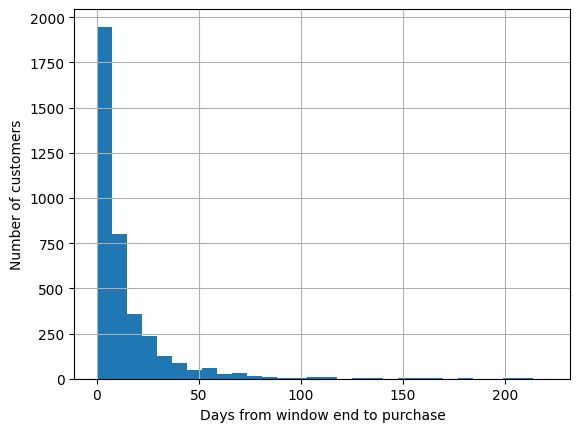

In [ ]:
# visualize with a histogram
import matplotlib.pyplot as plt
df['purchase_gap_from_window_end'].hist(bins=30)
plt.xlabel('Days from window end to purchase')
plt.ylabel('Number of customers')


In [ ]:
# count how much activity happens before the window ends and which specific activity type happens the most in that period

# Count total events per customer
activity_counts = full_events_in_windows.groupby('CUSTOMER_ID')['EVENT_TIMESTAMP'].count().reset_index(name='n_events_total')


In [ ]:
# Find each customer's last event timestamp
last_events = full_events_in_windows.groupby('CUSTOMER_ID')['EVENT_TIMESTAMP'].max().reset_index(name='last_event_ts')


In [ ]:
# Merge with window end times
activity_summary = (
    last_events
    .merge(windows[['CUSTOMER_ID', 'window_end']], on='CUSTOMER_ID', how='left')
    .merge(activity_counts, on='CUSTOMER_ID', how='left')
)


In [ ]:
# Ensure both columns are datetime
activity_summary['window_end'] = pd.to_datetime(activity_summary['window_end'], errors='coerce')
activity_summary['last_event_ts'] = pd.to_datetime(activity_summary['last_event_ts'], errors='coerce')

# Calculate gap between last event and window end (in days)
activity_summary['gap_last_event_to_window_end'] = (
    (activity_summary['window_end'] - activity_summary['last_event_ts']).dt.total_seconds() / 86400
)


In [ ]:
# Find which ACTIVITY_TYPE happens most often in this window
top_activity = (
    full_events_in_windows.groupby('EVENT_NAME')['EVENT_TIMESTAMP']
    .count()
    .reset_index(name='activity_count')
    .sort_values('activity_count', ascending=False)
)

In [ ]:
# Print and summarize
print("🔹 Activity Summary (first 10 customers):")
print(activity_summary[['CUSTOMER_ID', 'n_events_total', 'gap_last_event_to_window_end']].head(10))

🔹 Activity Summary (first 10 customers):
   CUSTOMER_ID  n_events_total  gap_last_event_to_window_end
0    500245685             751                   -157.885298
1    500245685             751                   -150.885298
2    500245685             751                   -143.885298
3    500245685             751                   -136.885298
4    500245685             751                   -129.885298
5    500245685             751                   -122.885298
6    500245685             751                   -115.885298
7    500245685             751                   -108.885298
8    500245685             751                   -101.885298
9    500245685             751                    -94.885298


In [ ]:
# print resutlts
print("\n Average number of events per customer:", round(activity_summary['n_events_total'].mean(), 2))
print(" Average gap (days) between last event and window end:", round(activity_summary['gap_last_event_to_window_end'].mean(), 2))

print("\n Top 10 Most Common Activity Types:")
print(top_activity.head(10))


 Average number of events per customer: 1330.74
 Average gap (days) between last event and window end: 41.14

 Top 10 Most Common Activity Types:
              EVENT_NAME  activity_count
129            page_view         1444145
118         button_click          896765
146       view_item_list          718295
142          update_cart          282969
113          add_to_cart          265830
127       nav_link_click          179454
149     view_site_search          138977
131  proceed_to_checkout          120613
143      user_engagement          111212
135          screen_view          101438


In [ ]:
# Convert timestamps to datetime so they match exactly
for df in [full_events_in_windows, win_with_recovery]:
    df['window_start'] = pd.to_datetime(df['window_start'])
    df['window_end'] = pd.to_datetime(df['window_end'])

In [ ]:
# Merge full_event_with_window and win_with_recovery table
for df in [full_events_in_windows, win_with_recovery]:
    df['window_start'] = pd.to_datetime(df['window_start']).dt.tz_localize(None)
    df['window_end'] = pd.to_datetime(df['window_end']).dt.tz_localize(None)


merged_df = full_events_in_windows.merge(
    win_with_recovery[['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end']],
    on=['CUSTOMER_ID', 'window_start', 'window_end'],
    how='left'
)


In [ ]:
# Rename for clarity
merged_df = merged_df.rename(columns={'Recovered_before_next_window_end': 'Recovered'})

In [ ]:
# Inspet
merged_df.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end,Abandoned,Recovered
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00,2025-04-09 22:00:00,0.0,0.0
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00,2025-04-08 21:00:00,0.0,0.0
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00,2025-04-08 21:00:00,0.0,0.0
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00,2025-04-10 21:00:00,0.0,0.0
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00,2025-04-10 21:00:00,0.0,0.0


In [ ]:
# Event name view
merged_df['EVENT_NAME'].value_counts().head()

,count
EVENT_NAME,
page_view,1447878
button_click,899754
view_item_list,722012
update_cart,283791
add_to_cart,267020


In [ ]:
# Number of unique event name types
num_event_names = full_events_in_windows['EVENT_NAME'].nunique()
print(f"Number of unique event names: {num_event_names}")

# List of all unique event names
event_list = full_events_in_windows['EVENT_NAME'].unique().tolist()
print("\nList of event names:")
for event in event_list:
    print("-", event)

Number of unique event names: 150

List of event names:
- view_search_results
- view_item_list
- purchase
- user_engagement
- ProductsList_PLP_Retrieved
- page_view
- pay_invoice_click
- screen_view
- button_click
- proceed_to_checkout
- update_cart
- begin_checkout
- add_to_cart
- view_site_search
- UpdateCart_Cart_Retrieved
- nav_link_click
- Close_SwitchAccount_Clicked
- os_update
- session_start
- ProductCount_PLP
- ProductAddtoCart_PLP_Clicked
- add_payment_info
- CheckoutPage_Displayed
- remove_from_cart
- Categories_PLP_Retrieved
- TicketList_CST_Retrieve_Failed
- UpdateCart_Cart_Clicked
- SwitchAccountPopup_Dispayed
- Images_PDP_Reteieved
- CartPage_Displayed
- view_item
- select_item
- ProductCheckmark_Cart_Checked
- application_launched
- Get_Order_History_Failed
- BackClicked_PDP
- Get_Banner_Images_Time_Comparison
- view_cart
- Update_Cart_Item_With_Price_Data_Failed
- logout
- Get_Banner_Images_Plp_Count
- ProfilePopup_Displayed
- Login_Home_Page_Displayed
- login
- Checko

In [ ]:
# All event names you have
all_event_names = [
    'view_search_results','view_item_list','purchase','user_engagement','ProductsList_PLP_Retrieved',
    'page_view','pay_invoice_click','screen_view','button_click','proceed_to_checkout','update_cart',
    'begin_checkout','add_to_cart','view_site_search','UpdateCart_Cart_Retrieved','nav_link_click',
    'Close_SwitchAccount_Clicked','os_update','session_start','ProductCount_PLP','ProductAddtoCart_PLP_Clicked',
    'add_payment_info','CheckoutPage_Displayed','remove_from_cart','Categories_PLP_Retrieved',
    'TicketList_CST_Retrieve_Failed','UpdateCart_Cart_Clicked','SwitchAccountPopup_Dispayed',
    'Images_PDP_Reteieved','CartPage_Displayed','view_item','select_item','ProductCheckmark_Cart_Checked',
    'application_launched','Get_Order_History_Failed','BackClicked_PDP','Get_Banner_Images_Time_Comparison',
    'view_cart','Update_Cart_Item_With_Price_Data_Failed','logout','Get_Banner_Images_Plp_Count',
    'ProfilePopup_Displayed','Login_Home_Page_Displayed','login','CheckoutData_Retrieve_Failed',
    'Error_post_create_webcart','AML_Validation_Failed','Logout_Profile_Clicked','Get_Banner_Images_Dashboard_Count',
    'app_update','CheckoutData_CheckoutPage_Retrieved','Login_Clicked','select_promotion','view_promotion',
    'first_visit','ProductSelected_Cart_Clicked','CartProductQuantity_Cart_Changed','filter_by',
    'OrderSuccessPage_Displayed','TicketList_EST_Retrieve_Failed','Create_Delivery_Quantity_Failed',
    'create_ticket','SupportTab_Displayed','export_cart_click','search_invoice','InvoiceList_InvoiceTab_Retrieved',
    'Get_Delivery_Dates_Api_Failed','RecentPayedInvoice_InvoiceTab_Clicked','refund',
    'Get_Is_Dom_Enabled_Failed','Error_Updating_Session_Delivery','OrderTab_Displayed','ProductAddtoCart_PDP_Clicked',
    'Update_Cart_With_Details_Failed','AccountSelect_SwitchAccount_Completed','AccountSelect_SwitchAccount_Clicked',
    'Login_Cancelled','Update_Cart_Details_For_Payment_Failed','Is_Account_Blocked_For_Ordering_Failed',
    'ProductCount_PDP','Post_Create_ESTCST_Ticket_Failed','add_shipping_info','Get_Invoice_Data_Failed',
    'Fetch_Menu_Access_Failed','TicketList_EST_Retrieved','Close_Profile_Clicked','search_order_history',
    'Error_Get_cart_data','Get_Bottler_Meta_Data_Failed','Get_User_Details_From_User_Id_Failed',
    'On_Proceed_To_Checkout_Click_Failed','sort_by','Update_Web_Cart_Failed','ContinueShopping_Cart_Clicked',
    'BackClicked_CST','Ticked_EST_Clicked','Get_Account_Details_Failed','SelectAll_Cart_Checked',
    'Account_Pressed_Failed','Error_Delivery_Method','Error_Handle_Payment_Method','Get_Recent_Order_Data_Failed',
    'SelectAll_Cart_Unchecked','Ticket_EST_Displayed','ProductCheckmark_Cart_Unchecked','TicketSearch_CST_Clicked',
    'CloseTicket_EST_Clicked','Get_Active_Cart_Items_Failed','Get_Web_Store_Failed','ProductsList_PLP_Retrieve_Failed',
    'Check_Prod_For_AML_And_Inventory_Failed','Get_Banner_Images_Failed','Images_PDP_Reteieve_Failed',
    'OrderSubmit_CheckoutPage_Failed','Get_Assortment_Product_List_Failed','Get_Product_Quantity_In_Cart_Failed',
    'Get_Delegated_Account_Failed','Payment_API_Failed','InvoiceList_InvoiceTab_Retrieve_Failed',
    'InvoiceListFilter_InvoiceTab_Successfull','Get_Oct_Invoice_Failed','Get_Payment_Method_Failed',
    'TicketSearch_EST_Clicked','Get_Invoice_Details_Failed','Maintenance_Flag_Successful','TicketList_CST_Retrieved',
    'CartProducts_Cart_Retrieve_Failed','Handle_Auth_Success_Failed','CloseTicket_EST_Successful',
    'TicketListFilter_EST_Successfull','TicketListFilter_CST_Successfull','Process_Payment_Error',
    'Get_Account_Easy_Order_Failed','Logout_Profile_Failed','Ticked_CST_Clicked','Get_Filter_Options_Failed',
    'Get_Order_History_Filter_Options_Failed','ProductAddtoCart_PLP_Failed','Get_Cart_Count_Failed',
    'Handle_Add_To_Cart_Failed','Error_get_webcart_details','handle_save_azure_key_failed','app_remove',
    'Get_Payment_Methods_Data_Failed','Ticket_CST_Displayed','homepage_register_now','Delete_Order_History_Cache_Failed',
    'Get_Decision_Tree_Data_Failed','Get_SnapPay_Mapping_MetaData_Failed','SSO_Token_Details_Failed'
]

# Exclude only literal purchase-confirmation events
features = [e for e in all_event_names if e not in ['purchase', 'OrderSuccessPage_Displayed']]

print("Features selected for abandonment model:", features)


Features selected for abandonment model: ['view_search_results', 'view_item_list', 'user_engagement', 'ProductsList_PLP_Retrieved', 'page_view', 'pay_invoice_click', 'screen_view', 'button_click', 'proceed_to_checkout', 'update_cart', 'begin_checkout', 'add_to_cart', 'view_site_search', 'UpdateCart_Cart_Retrieved', 'nav_link_click', 'Close_SwitchAccount_Clicked', 'os_update', 'session_start', 'ProductCount_PLP', 'ProductAddtoCart_PLP_Clicked', 'add_payment_info', 'CheckoutPage_Displayed', 'remove_from_cart', 'Categories_PLP_Retrieved', 'TicketList_CST_Retrieve_Failed', 'UpdateCart_Cart_Clicked', 'SwitchAccountPopup_Dispayed', 'Images_PDP_Reteieved', 'CartPage_Displayed', 'view_item', 'select_item', 'ProductCheckmark_Cart_Checked', 'application_launched', 'Get_Order_History_Failed', 'BackClicked_PDP', 'Get_Banner_Images_Time_Comparison', 'view_cart', 'Update_Cart_Item_With_Price_Data_Failed', 'logout', 'Get_Banner_Images_Plp_Count', 'ProfilePopup_Displayed', 'Login_Home_Page_Displayed',

### Logistic Regression

In [ ]:
# Filter out purchase-confirmation events
filtered_df = merged_df[merged_df['EVENT_NAME'].isin(features + ['Abandoned', 'Recovered'])]

# Pivot events into wide format
pivot_df = (
    filtered_df
    .assign(flag=1)
    .pivot_table(
        index='CUSTOMER_ID',
        columns='EVENT_NAME',
        values='flag',
        aggfunc='sum',
        fill_value=0
    )
    .reset_index()
)

# Merge target columns back
pivot_df = pivot_df.merge(
    merged_df[['CUSTOMER_ID', 'Abandoned', 'Recovered']].drop_duplicates(),
    on='CUSTOMER_ID',
    how='left'
)

# Drop any rows where Abandoned or Recovered is NaN
pivot_df = pivot_df.dropna(subset=['Abandoned', 'Recovered'])


In [ ]:
# Logistic Regression for Abandoned

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_ab = pivot_df[features]
y_ab = pivot_df['Abandoned']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_ab, y_ab, test_size=0.3, random_state=42)

# Logistic regression
lr_ab = LogisticRegression(max_iter=1000)
lr_ab.fit(X_train, y_train)

# Predictions
y_pred = lr_ab.predict(X_test)

# Evaluation
print("Abandoned Logistic Regression Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Abandoned Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.60      0.87      0.71      1110
         1.0       0.53      0.21      0.30       819

    accuracy                           0.59      1929
   macro avg       0.56      0.54      0.50      1929
weighted avg       0.57      0.59      0.53      1929

Confusion Matrix:
 [[962 148]
 [651 168]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Logistic Regression for Recovered

X_rec = pivot_df[features]
y_rec = pivot_df['Recovered']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec, test_size=0.3, random_state=42)

# Logistic regression
lr_rec = LogisticRegression(max_iter=1000)
lr_rec.fit(X_train, y_train)

# Predictions
y_pred = lr_rec.predict(X_test)

# Evaluation
print("Recovered Logistic Regression Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Recovered Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87      1498
         1.0       0.13      0.01      0.02       431

    accuracy                           0.77      1929
   macro avg       0.45      0.50      0.44      1929
weighted avg       0.63      0.77      0.68      1929

Confusion Matrix:
 [[1472   26]
 [ 427    4]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
